In [1]:
!pip install nltk pandas matplotlib seaborn wordcloud networkx arabic-reshaper python-bidi

In [2]:
! pip install fasttext-wheel

! pip install -q -U datasets
! pip install -q pandas
! pip install -q scikit-learn
! pip install -q seaborn

! pip install -q arabic-reshaper
! pip install -q wordcloud
! pip install -q python-bidi

In [3]:
import pandas as pd
import re
import unicodedata

In [4]:
df = pd.read_csv('assets/data/articles.csv')
df.head()

,Unnamed: 0,title,date,contentLink,content
0,0,تبون تلقى مستشار ترامب وهدرو على نزاع الصحرا و...,20 ساعة Ago,https://www.goud.ma/%d8%aa%d8%a8%d9%88%d9%86-%...,الوالي الزاز -كود- العيون////\n[email protecte...
1,1,من بعد تونس وليبيا.. مستشار ترامب بدا زيارتو ل...,20 ساعة Ago,https://www.goud.ma/%d9%85%d9%86-%d8%a8%d8%b9%...,الوالي الزاز -كود- العيون////\n[email protecte...
2,2,بريطانيا لمواطنيها.. ردو البال المغرب ماكيتفاه...,21 ساعة Ago,https://www.goud.ma/%d8%a8%d8%b1%d9%8a%d8%b7%d...,أنس العمري – كود///\nحذرت المملكة المتحدة مواط...
3,3,حرب النفوذ السياسي انتقل لـ”المهرجانات”.. شركة...,1 يوم Ago,https://www.goud.ma/%d8%ad%d8%b1%d8%a8-%d8%a7%...,كود الرباط//\nالسياسة فكولشي، من الرياضة للثقا...
4,4,السياح المغاربة مكرهين بسباب ثمن لوطيلات والخد...,1 يوم Ago,https://www.goud.ma/%d8%a7%d9%84%d8%b3%d9%8a%d...,سعيد الشاوي – كود///\nالعطلة الصيفية 2025 مزال...


In [5]:
df.shape

(10215, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10215 entries, 0 to 10214
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10215 non-null  int64 
 1   title        10215 non-null  object
 2   date         10215 non-null  object
 3   contentLink  10215 non-null  object
 4   content      10208 non-null  object
dtypes: int64(1), object(4)
memory usage: 399.1+ KB


# I- Data Cleaning:

In [7]:
# Extracting characters from the 'content' column
characters = set()
for row in df['content']:
    characters.update(str(row))

len(characters)

349

In [8]:
ARABIC_DIACRITICS = re.compile(r'[\u0610-\u061A\u064B-\u065F\u06D6-\u06ED\u200f]')
TATWEEL = 'ـ'
EASTERN_AR_NUMS = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")

def clean_darija(text):
    text = str(text)
    text = unicodedata.normalize("NFKC", text)             # Normalize Unicode
    text = text.translate(EASTERN_AR_NUMS)                 # Convert Eastern Arabic numerals to 0–9
    text = text.replace(TATWEEL, '')                       # Remove Tatweel
    text = ARABIC_DIACRITICS.sub('', text)                 # Remove diacritics
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'
                  r'\uFB50-\uFDFF\uFE70-\uFEFF\n0-9 ]+', '', text)  # Keep Arabic, numbers, space, \n
    text = re.sub(r'[^\S\n]+', ' ', text).strip()          # Normalize spaces, preserve \n
    return text


In [9]:
# Clean the 'content' column
df['content'] = df['content'].astype(str)  # Ensure all content is string
df['content'].drop_duplicates(inplace=True)  
df['content'].dropna(inplace=True)
df['content'] = df['content'].apply(clean_darija)  

In [10]:
characters = set()
for row in df['content']:
    characters.update(str(row))

len(characters)

68

In [11]:
df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore') 

In [12]:
df.select_dtypes('object').describe()

,title,date,contentLink,content
count,10215,10215,10215,10215
unique,10185,10110,10187,10188
top,شكاية بلا نهاية فالجنوب.. تالفة 10 شهر هادي بي...,2 يومين Ago,https://www.goud.ma/%d8%a7%d9%84%d9%85%d8%b1%d...,
freq,5,21,5,7


In [13]:
# Remove duplicates:
df = df.drop_duplicates(subset='content')
df = df.drop_duplicates(subset=['contentLink'])

In [14]:
df['contentLength'] = df['content'].str.len()

In [15]:
df['contentLength'].describe()

count    10181.000000
mean      1204.544740
std        891.836105
min          0.000000
25%        702.000000
50%        978.000000
75%       1401.000000
max      17240.000000
Name: contentLength, dtype: float64

In [16]:
# Remove rows with content length less than 30 characters
df = df[df['contentLength'] >= 30]

In [17]:
# Remove ponctuation and special characters
def remove_ponct(tweet):
    ponct_re = r"[^\w\s]+"
    return re.sub(ponct_re, ' ', tweet)

df['content'] = df['content'].apply(remove_ponct)

In [18]:
df.to_csv('assets/data/articles_cleaned.csv', index=False)

# II- Natural Language Processing

In [19]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\UM6P\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
def Tokenize(content):
    return word_tokenize(content)

df["contentToken"] = df['content'].apply(Tokenize)
df.head()

,title,date,contentLink,content,contentLength,contentToken
0,تبون تلقى مستشار ترامب وهدرو على نزاع الصحرا و...,20 ساعة Ago,https://www.goud.ma/%d8%aa%d8%a8%d9%88%d9%86-%...,الوالي الزاز كود العيون\n \nتلقى الرئيس الجزائ...,1257,"[الوالي, الزاز, كود, العيون, تلقى, الرئيس, الج..."
1,من بعد تونس وليبيا.. مستشار ترامب بدا زيارتو ل...,20 ساعة Ago,https://www.goud.ma/%d9%85%d9%86-%d8%a8%d8%b9%...,الوالي الزاز كود العيون\n \nبدا مستشار الرئيس ...,1498,"[الوالي, الزاز, كود, العيون, بدا, مستشار, الرئ..."
2,بريطانيا لمواطنيها.. ردو البال المغرب ماكيتفاه...,21 ساعة Ago,https://www.goud.ma/%d8%a8%d8%b1%d9%8a%d8%b7%d...,أنس العمري كود\nحذرت المملكة المتحدة مواطنيها ...,1093,"[أنس, العمري, كود, حذرت, المملكة, المتحدة, موا..."
3,حرب النفوذ السياسي انتقل لـ”المهرجانات”.. شركة...,1 يوم Ago,https://www.goud.ma/%d8%ad%d8%b1%d8%a8-%d8%a7%...,كود الرباط\nالسياسة فكولشي من الرياضة للثقافة...,2474,"[كود, الرباط, السياسة, فكولشي, من, الرياضة, لل..."
4,السياح المغاربة مكرهين بسباب ثمن لوطيلات والخد...,1 يوم Ago,https://www.goud.ma/%d8%a7%d9%84%d8%b3%d9%8a%d...,سعيد الشاوي كود\nالعطلة الصيفية 2025 مزال مستم...,1213,"[سعيد, الشاوي, كود, العطلة, الصيفية, 2025, مزا..."


In [21]:
#Import darija stopwords dataset
stopwords = pd.read_csv("assets/darijaStopWord.csv")
stopwords = stopwords['word'].tolist()
stopwords = {stp_wrd.strip() for stp_wrd in stopwords} # Faster lookup

def remove_stop(all_tokens):
    return [token.strip() for token in all_tokens if token.strip() not in stopwords] 

df['contentToken'] = df['contentToken'].apply(remove_stop)
allTokens = [token for list_token in df['contentToken'] for token in list_token]
df.head()

,title,date,contentLink,content,contentLength,contentToken
0,تبون تلقى مستشار ترامب وهدرو على نزاع الصحرا و...,20 ساعة Ago,https://www.goud.ma/%d8%aa%d8%a8%d9%88%d9%86-%...,الوالي الزاز كود العيون\n \nتلقى الرئيس الجزائ...,1257,"[الوالي, الزاز, كود, العيون, تلقى, الرئيس, الج..."
1,من بعد تونس وليبيا.. مستشار ترامب بدا زيارتو ل...,20 ساعة Ago,https://www.goud.ma/%d9%85%d9%86-%d8%a8%d8%b9%...,الوالي الزاز كود العيون\n \nبدا مستشار الرئيس ...,1498,"[الوالي, الزاز, كود, العيون, بدا, مستشار, الرئ..."
2,بريطانيا لمواطنيها.. ردو البال المغرب ماكيتفاه...,21 ساعة Ago,https://www.goud.ma/%d8%a8%d8%b1%d9%8a%d8%b7%d...,أنس العمري كود\nحذرت المملكة المتحدة مواطنيها ...,1093,"[أنس, العمري, كود, حذرت, المملكة, المتحدة, موا..."
3,حرب النفوذ السياسي انتقل لـ”المهرجانات”.. شركة...,1 يوم Ago,https://www.goud.ma/%d8%ad%d8%b1%d8%a8-%d8%a7%...,كود الرباط\nالسياسة فكولشي من الرياضة للثقافة...,2474,"[كود, الرباط, السياسة, فكولشي, الرياضة, للثقاف..."
4,السياح المغاربة مكرهين بسباب ثمن لوطيلات والخد...,1 يوم Ago,https://www.goud.ma/%d8%a7%d9%84%d8%b3%d9%8a%d...,سعيد الشاوي كود\nالعطلة الصيفية 2025 مزال مستم...,1213,"[سعيد, الشاوي, كود, العطلة, الصيفية, 2025, مست..."


# III- Some analysis

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

C:\Users\UM6P\AppData\Local\Temp\ipykernel_22864\1841483293.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=bidi_words, palette="viridis")


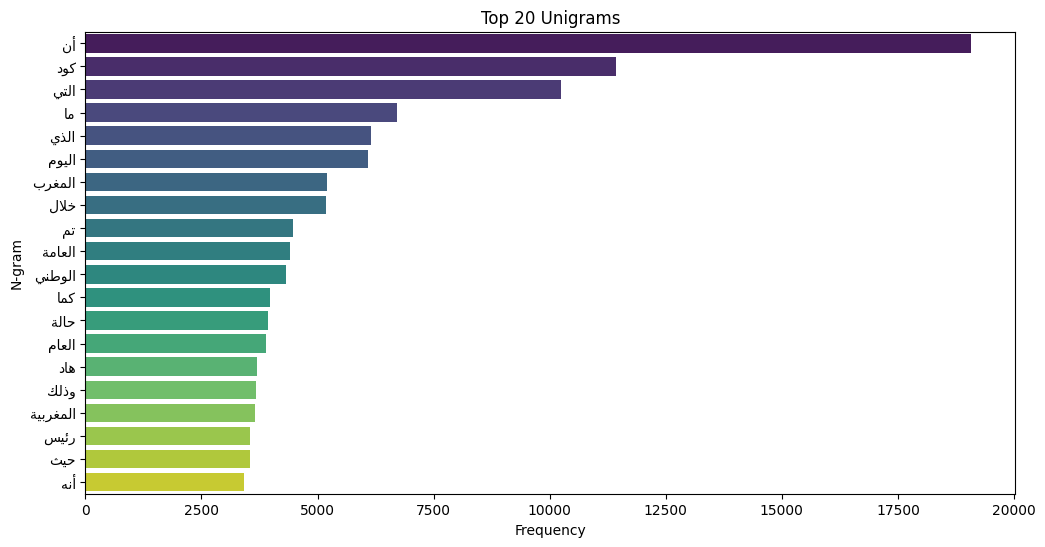

In [23]:
unigram_counts = Counter(allTokens)

def plot_top_n_grams(ngram_counts, n, title):
    top_n = ngram_counts.most_common(n)
    words, counts = zip(*top_n)
    plt.figure(figsize=(12, 6))
    reshaped_words = [arabic_reshaper.reshape(word) for word in words]
    bidi_words = [get_display(word) for word in reshaped_words]
    sns.barplot(x=list(counts), y=bidi_words, palette="viridis")
    plt.title(f"Top {n} {title}")
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.show()

plot_top_n_grams(unigram_counts, 20, "Unigrams")

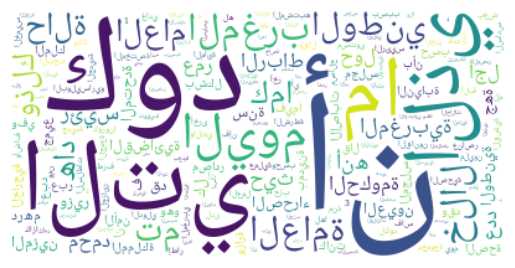

In [24]:
cloud_ar = WordCloud(font_path='assets/NotoNaskhArabic-VariableFont_wght.ttf', background_color="white").generate_from_frequencies(unigram_counts)
plt.imshow(cloud_ar, interpolation='bilinear')
plt.axis('off')

plt.show()

In [25]:
df.to_csv('assets/data/articles_tokenized.csv', index=False)

# IV - Language Identification

In [26]:
import fasttext
import re
import arabic_reshaper

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bidi.algorithm import get_display
from collections import Counter
from heapq import nlargest
from wordcloud import WordCloud

from datasets import load_dataset

c:\Users\UM6P\anaconda3\envs\LLMChallenge\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
dataset = load_dataset("atlasia/Darija-LID")

train_data = dataset['train']
test_data = dataset['test']

train_data = train_data.to_pandas()
test_data = test_data.to_pandas()

train_data.to_csv('assets/data-LID/train_Darija_LID.csv', index=False)
test_data.to_csv('assets/data-LID/test_Darija_LID.csv', index=False)

In [28]:
# DO NOT DELETE/HIDE THIS FUNCTION
def validate_fasttext_format(file_path) -> dict:
    """Utility function to validate the format of the data for fasttext"""
    n_errors = 0
    emptylines = []
    labelmissing = []
    spacemissing = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            if not line.strip():
                #print(f"Empty line found at line {i}")
                emptylines.append(i)
                n_errors += 1
                continue
            if not line.startswith('__label__'):
                # print(f"Line {i} doesn't start with __label__: {line[:100]}")
                labelmissing.append(i)
                n_errors += 1
                continue
            if ' ' not in line:
                # print(f"Line {i} has no space after label: {line[:100]}")
                spacemissing.append(i)
                n_errors += 1
                continue
    errors_report = {
        'empty line': emptylines,
        '__label__ missing': labelmissing,
        'whitespace missing': spacemissing
        }
    print(f"Data format validation complete. Found {n_errors} errors.")
    return errors_report


def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # remove Latin characters but keep Arabic text
    text = re.sub(r'[a-zA-Z]', '', text)
    # remove emojis but keep Arabic text
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = text.lower()
    return text

train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

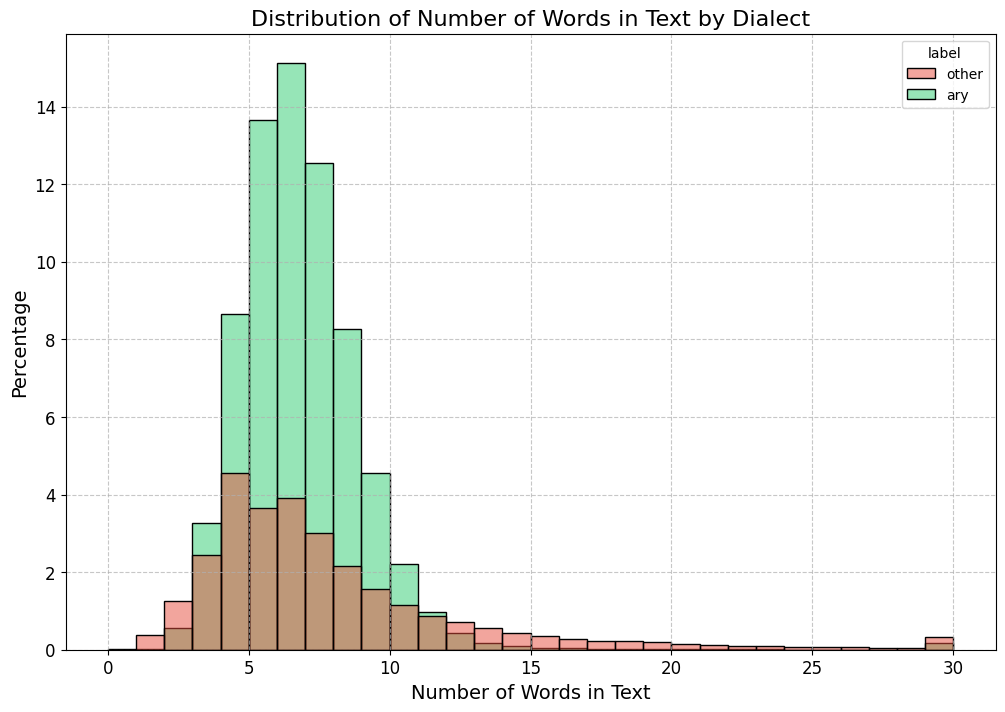

In [29]:
palette = {'ary': '#2ecc71', 'other': '#e74c3c'}

# recalculate text length
train_data['text_length'] = train_data['processed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 8))
sns.histplot(
    data=train_data.assign(text_length_clipped=train_data['text_length'].clip(upper=30)),
    x='text_length_clipped',
    hue='label',
    bins=30,
    palette=palette,
    multiple="layer",
    stat='percent'
)
plt.title('Distribution of Number of Words in Text by Dialect', fontsize=16)
plt.xlabel('Number of Words in Text', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

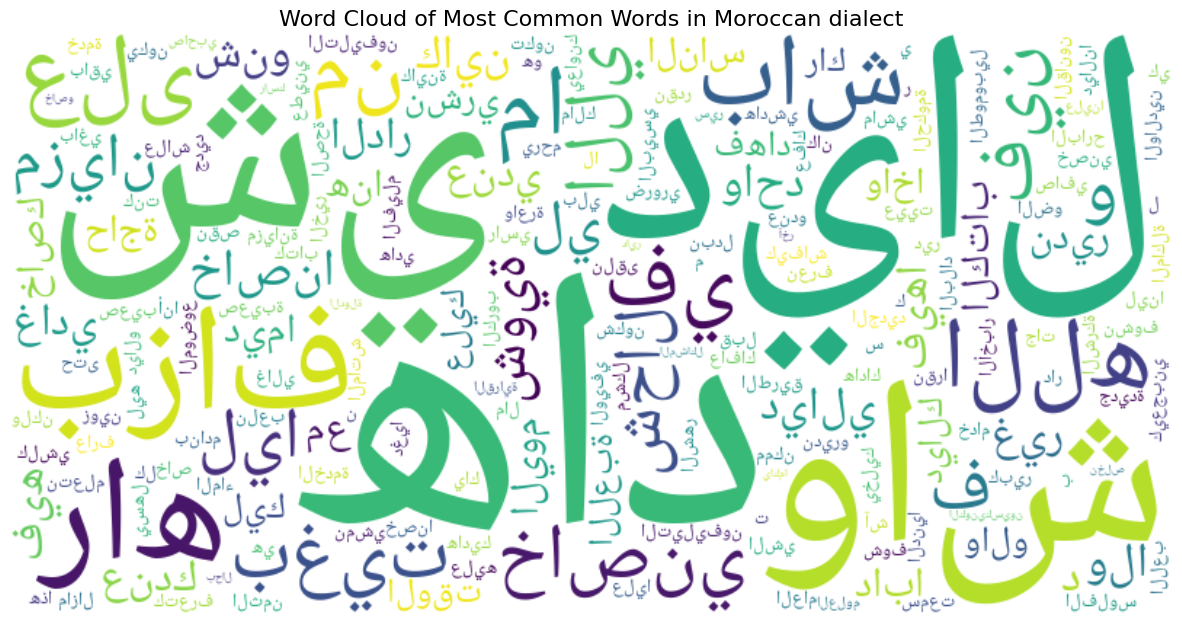

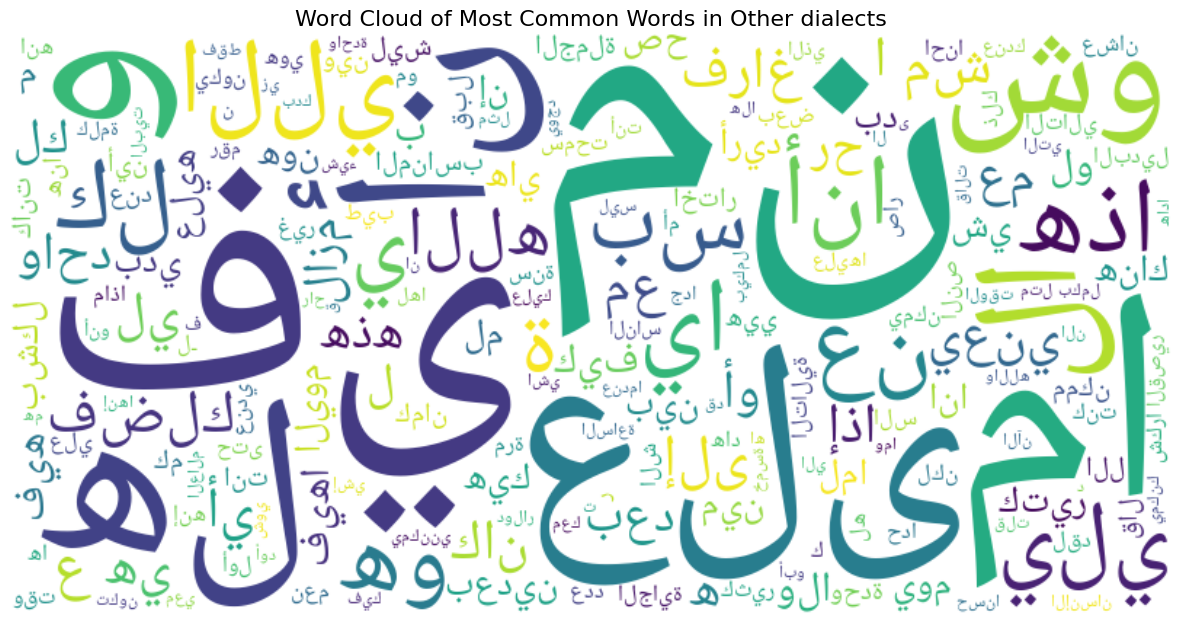

In [30]:
font_path = 'assets/NotoNaskhArabic-VariableFont_wght.ttf'

words_counts_ary = Counter(' '.join(train_data[train_data['label'] == 'ary']['processed_text']).split())
words_counts_other = Counter(' '.join(train_data[train_data['label'] == 'other']['processed_text']).split())

# Function to preprocess Arabic text
def preprocess_arabic_words(word_freq):
    reshaped_word_freq = {}
    for word, freq in word_freq.items():
        # Reshape and reorder the Arabic word
        reshaped_word_freq[word] = freq
    return reshaped_word_freq


# ------------------top 1k words in Ary------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_ary.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Moroccan dialect', fontsize=16)
plt.show()


# ------------------top 1k words in Other------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_other.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Other dialects', fontsize=16)
plt.show()


In [31]:
data_train = train_data[['label', 'processed_text']].copy()
data_train['label'] = '__label__' + data_train['label']

data_test = test_data[['label', 'processed_text']].copy()
data_test['label'] = '__label__' + data_test['label']

# save
data_train.to_csv('assets/data-LID/data_train.txt', header=None, index=None, sep=' ', mode='w')
data_test.to_csv('assets/data-LID/data_test.txt', header=None, index=None, sep=' ', mode='w')

In [32]:
_ = validate_fasttext_format('assets/data-LID/data_train.txt')
_ = validate_fasttext_format('assets/data-LID/data_test.txt') 

Data format validation complete. Found 0 errors.
Data format validation complete. Found 0 errors.


In [33]:
training_params = {
    "lr": 0.1,
    "epoch": 5,
    "dim": 100,
    "minCount": 1,
    "wordNgrams": 5,
    "bucket": 200,
    "loss": "softmax",
}
model = fasttext.train_supervised('assets/data-LID/data_train.txt', **training_params)

In [34]:
# Evaluation 

with open('assets/data-LID/data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)
# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]


Classification Report:
              precision    recall  f1-score   support

         ary       0.99      0.99      0.99     37761
       other       0.98      0.98      0.98     15465

    accuracy                           0.99     53226
   macro avg       0.98      0.98      0.98     53226
weighted avg       0.99      0.99      0.99     53226



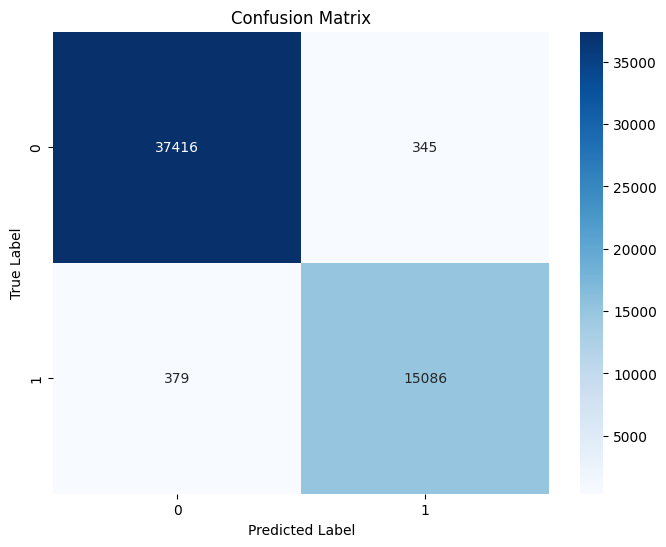

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, pos_label='ary')
recall = recall_score(y_true, y_hat, pos_label='ary')
f1 = f1_score(y_true, y_hat, pos_label='ary')


print("\nClassification Report:")
print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
# prepare validation data
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data_train, test_size=0.2, random_state=7)

# save validation data
val_data.to_csv('assets/data-LID/data_val.txt', header=None, index=None, sep=' ', mode='w')

In [ ]:
# FastText's built-in hyperparameter tuning

model = fasttext.train_supervised('assets/data-LID/data_train.txt', autotuneValidationFile='assets/data-LID/data_val.txt')

              precision    recall  f1-score   support

         ary       0.99      1.00      0.99     37761
       other       0.99      0.97      0.98     15465

    accuracy                           0.99     53226
   macro avg       0.99      0.98      0.98     53226
weighted avg       0.99      0.99      0.99     53226



Text(0.5, 36.72222222222221, 'Predicted Label')

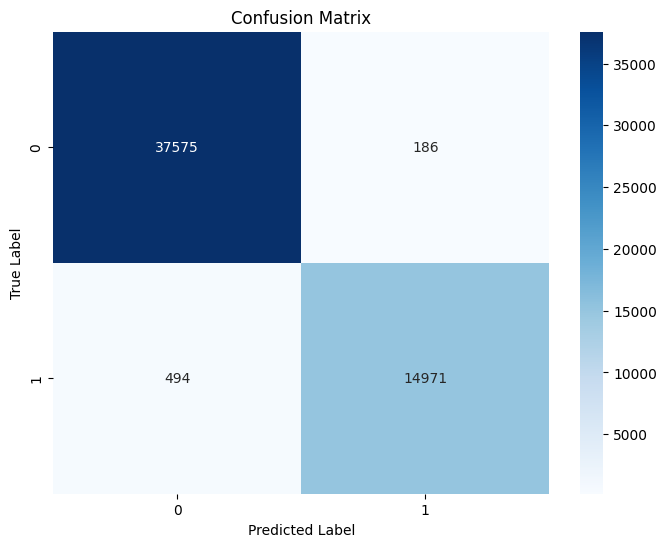

In [40]:
# Evaluate
with open('assets/data-LID/data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)

# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]

print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


In [41]:
model.save_model("assets/models/LID.ftz")